In [1]:
import numpy as np
import gymnasium as gym
import torch

import os 
import sys

sys.path.append(os.path.abspath('../..'))

from environment.env import POMDPDeformedGridworld

In [2]:
OBSERVATION_TYPE = 'cardinal' # 'cardinal' or  'single'
BELIEF_UPDATE = 'particlefilters' # 'discrete', 'variational' or 'particlefilters'
DISCRETIZATION = 2000 # 
DEBUG = False

# Load MDP solution

### PPO

In [25]:

run = "PPO_continous_" + "enh53x0u"

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO
from environment.env import Grid
from utils.checkpoints import find_last_checkpoint

env = Grid(
    shear_range=(-.2, .2),
    stretch_range=(.4,1),
    render_mode="human"
)

last_checkpoint = find_last_checkpoint(f"../../agents/pretrained/MDP/{run}")
model = PPO.load(f"../../agents/pretrained/MDP/{run}/{last_checkpoint}", env=env)


env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


### DQN

In [3]:

run = "DQN_continous_" + "e2qthdat"

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import DQN
from environment.env import Grid
from utils.checkpoints import find_last_checkpoint

env = Grid(
    shear_range=(-.2, .2),
    stretch_range=(.4,1),
    render_mode="human"
)


last_checkpoint = find_last_checkpoint(f"../../agents/pretrained/MDP/{run}")
print(last_checkpoint)
model = DQN.load(f"../../agents/pretrained/MDP/{run}/{last_checkpoint}", env=env)


env.close()

rl_model_4500000_steps
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


# Load Obs Model

In [4]:
def load_obs_model(obs_type):
    from observation_model.obs_model import singleNN, cardinalNN

    if obs_type == 'single':
        obs_model = singleNN()
        obs_model.load_state_dict(torch.load("obs_model_4.pth", weights_only=True,map_location=torch.device('cpu')))
    elif obs_type == 'cardinal':
        obs_model = cardinalNN()
        obs_model.load_state_dict(torch.load("obs_model_cardinal_4.pth", weights_only=True))
    else:
        raise ValueError("Observation type not recognized")
    
    return obs_model
obs_model = load_obs_model(OBSERVATION_TYPE)

# Pomdp agent

In [6]:
import torch
import numpy as np
from collections import OrderedDict
from stable_baselines3 import PPO


class POMDPAgent():
    
    def __init__(self,mdp_agent:PPO, pomdp_env: POMDPDeformedGridworld, discretization=10, update='discrete', obs_model=None, debug=False):
        assert isinstance(pomdp_env, POMDPDeformedGridworld), f'Invalid environment type {type(pomdp_env)}'
        self.pomdp_env = pomdp_env
        self.mdp_agent = mdp_agent
        self.update = update

        if update == 'discrete' or update == 'discrete_exact':
            stretch = np.linspace(.4, 1, discretization)
            shear = np.linspace(-.2,.2, discretization)
            xa,ya,yb,xb = np.meshgrid(stretch, shear,shear,stretch) # , shear, shear
            positions = np.column_stack([xa.ravel(),ya.ravel(),yb.ravel(),xb.ravel()]),
            positions = torch.tensor(np.array(positions), dtype=torch.float32)
            self.belief_points = positions.squeeze()
            self.belief_values = torch.ones(self.belief_points.shape[0], dtype=torch.float32, requires_grad=False) / len(positions)
            
            self.original_def = env.transformation_matrix[0][0], env.transformation_matrix[1][1]

        if update == 'discrete': 
            assert obs_model is not None, f'Need an observation model for discrete belief update, given {obs_model}'
            self.obs_model = obs_model
            self.belief_update = self.discrete_belief_update
            print('Discrete belief update with observation model - SHEAR allowed')
        elif update == 'discrete_exact':
            self.belief_update = self.exact_belief_update
            raise NotImplementedError('Exact belief update not implemented here')
        elif update == 'variational':
            from utils.belief import BetaVariationalBayesianInference
            assert obs_model is not None, f'Need an observation model for variational belief update, given {obs_model}'
            self.VI = BetaVariationalBayesianInference(obs_model, input_dim=2, latent_dim=4, debug=debug)
            self.obs_model = obs_model

            self.belief_update = self.variational_belief_update
            self.X_history = [self.pomdp_env.get_state()['pos']]
            self.y_history = [self.pomdp_env.get_state()['obs']]
        elif update == 'particlefilters':
            from utils.belief import BayesianParticleFilter
            self.obs_model = obs_model
            self.n_particles = discretization
            self.PF = BayesianParticleFilter(f = obs_model, n_particles=self.n_particles, theta_dim=4)
            self.PF.initialize_particles()
            self.belief_update = self.particle_filter_belief_update
            
            self.X_history = [self.pomdp_env.get_state()['pos']]
            self.y_history = [self.pomdp_env.get_state()['obs']]

        else:
            raise ValueError('Invalid belief update method')
        
        self.debug = debug
        if self.debug:
            print(f'Using {update} belief update method')
    
    def predict(self, s, deterministic=True):
        
        self.belief_update(s)
        pos = s['pos']
        if self.update == 'discrete_exact' or self.update == 'discrete':
            # theta = self.belief_points[self.belief_values.argmax()] # QMDP
            theta = self.belief_points[torch.multinomial(self.belief_values, 1).item()] #  sampling
        elif self.update == 'variational':
            theta = self.VI.sample_latent(1).squeeze().clone().detach().numpy() # variational sampling
        elif self.update == 'particlefilters':
            mean, var = self.PF.estimate_posterior()
            theta = torch.distributions.Normal(torch.tensor(mean), torch.tensor(var).sqrt()+1e-6).sample().squeeze()
            # theta = torch.tensor(mean, dtype=torch.float32)

        s = OrderedDict({'pos': pos, 'theta': theta})
        action = self.mdp_agent.predict(s, deterministic=deterministic)

        self.on_precidt_callback()
        return action
    
    def discrete_belief_update(self, pomdp_state):
        """discrete belief update"""
        pos = pomdp_state['pos']
        obs = pomdp_state['obs']

        batch_pos = pos.repeat(len(self.belief_points), 1)

        with torch.no_grad():
            predictions = self.obs_model(batch_pos,self.belief_points)

        # likelihood = torch.exp(torch.distributions.Bernoulli(predictions).log_prob(obs))
        # if len(likelihood.shape) == 2:
        #     likelihood = likelihood.sum(dim=1)
        likelihood = torch.distributions.Bernoulli(predictions).log_prob(obs)
        if len(likelihood.shape) == 2:
            likelihood = likelihood.sum(dim=1)
        likelihood = torch.exp(likelihood)

        tmp = likelihood.squeeze() * self.belief_values
        self.belief_values = tmp  / tmp.sum()

    def exact_belief_update(self, pomdp_state):
        """discrete belief update"""
        obs = pomdp_state['obs']
        pos = pomdp_state['pos']

        def f():
            likelihood = []
            for x in self.belief_points:
                try:
                    self.pomdp_env.set_deformation([x[0], x[1]],[0,0]) # stretch, shear format
                    likelihood.append(torch.all(torch.tensor(self.pomdp_env.observe(list(pos))) == obs))
                except:
                    raise ValueError('Invalid belief point x', x)
            self.pomdp_env.set_deformation(self.original_def, [0,0])
            return torch.tensor(likelihood, dtype=torch.float32)

        
        likelihood = f()
        self.belief_values =  likelihood * self.belief_values
        self.belief_values = self.belief_values / self.belief_values.sum()

    def variational_belief_update(self, pomdp_state):
        self.X_history.append(pomdp_state['pos'])
        self.y_history.append(pomdp_state['obs'])

        # X = posizione dell'agente (x,y)
        X = torch.stack(self.X_history)

        # ossevrazioni dell'agente negli stati pos=(x,y)
        y = torch.stack(self.y_history)

        # Create and fit the model
        self.VI.fit(X, y, n_epochs=10, lr=0.05)

    def particle_filter_belief_update(self, pomdp_state):
        self.X_history.append(pomdp_state['pos'])
        self.y_history.append(pomdp_state['obs'])

        # X = posizione dell'agente (x,y)
        X = torch.stack(self.X_history[-1:])

        # ossevrazioni dell'agente negli stati pos=(x,y)
        y = torch.stack(self.y_history[-1:])

        print(X.shape, y.shape)

        # X, y = pomdp_state['pos'].unsqueeze(0), pomdp_state['obs'].unsqueeze(0)

        # Create and fit the model
        self.PF.update(X, y)

    def on_precidt_callback(self):
        if self.debug:
            self.print_stats()
        
    def print_stats(self):
        if self.update == 'discrete':
            # print(f'Belief shape: {self.belief_values.shape}')
            # print(f'Belief points shape: {self.belief_points.shape}')
            # print(f'Belief max: {self.belief_points[self.belief_values.argmax()]}')
            # print(f'Belief sum: {self.belief_values.sum()}')
            # print(f'Belief entropy: {torch.distributions.Categorical(probs=self.belief_values).entropy()}')
            # print("\n")
            self.entropy = torch.distributions.Categorical(probs=self.belief_values).entropy()
        elif self.update == 'variational':
            # print(f'Variational inference: {self.VI.entropy()}')
            # print(self.VI.get_posterior_params())
            # print("\n")
            self.entropy = self.VI.entropy()
        elif self.update == 'particlefilters':
            # print(f'Particle filter: {self.PF.estimate_posterior()[1]}')
            # print("\n")
            self.entropy = self.PF.entropy()
        
    def reset(self):
        self.X_history = [self.pomdp_env.get_state()['pos']]
        self.y_history = [self.pomdp_env.get_state()['obs']]
        self.entropy = None

        if self.update == 'discrete':
            self.belief_values = torch.ones(self.belief_points.shape[0], dtype=torch.float32, requires_grad=False) / len(self.belief_points)
        elif self.update == 'variational':
            del self.VI
            from utils.belief import BetaVariationalBayesianInference
            self.VI = BetaVariationalBayesianInference(self.obs_model, input_dim=2, latent_dim=4, debug=self.debug)
        elif self.update == 'particlefilters':
            del self.PF
            from utils.belief import BayesianParticleFilter
            self.PF = BayesianParticleFilter(f = self.obs_model, n_particles=self.n_particles, theta_dim=4)
            self.PF.initialize_particles()

In [6]:
import torch
import numpy as np
from collections import OrderedDict
from stable_baselines3 import PPO


class MLSAgent():
    
    def __init__(self,mdp_agent:PPO, pomdp_env: POMDPDeformedGridworld, discretization=10, update='discrete', obs_model=None, debug=False):
        assert isinstance(pomdp_env, POMDPDeformedGridworld), f'Invalid environment type {type(pomdp_env)}'
        self.pomdp_env = pomdp_env
        self.mdp_agent = mdp_agent
        self.update = update

        if update == 'discrete' or update == 'discrete_exact':
            stretch = np.linspace(.4, 1, discretization)
            shear = np.linspace(-.2,.2, discretization)
            xa,ya,yb,xb = np.meshgrid(stretch, shear,shear,stretch) # , shear, shear
            positions = np.column_stack([xa.ravel(),ya.ravel(),yb.ravel(),xb.ravel()]),
            positions = torch.tensor(np.array(positions), dtype=torch.float32)
            self.belief_points = positions.squeeze()
            self.belief_values = torch.ones(self.belief_points.shape[0], dtype=torch.float32, requires_grad=False) / len(positions)
            
            self.original_def = env.transformation_matrix[0][0], env.transformation_matrix[1][1]

        if update == 'discrete': 
            assert obs_model is not None, f'Need an observation model for discrete belief update, given {obs_model}'
            self.obs_model = obs_model
            self.belief_update = self.discrete_belief_update
            print('Discrete belief update with observation model - SHEAR allowed')
        elif update == 'discrete_exact':
            self.belief_update = self.exact_belief_update
            raise NotImplementedError('Exact belief update not implemented here')
        elif update == 'variational':
            from utils.belief import BetaVariationalBayesianInference
            assert obs_model is not None, f'Need an observation model for variational belief update, given {obs_model}'
            self.VI = BetaVariationalBayesianInference(obs_model, input_dim=2, latent_dim=4, debug=debug)
            self.obs_model = obs_model

            self.belief_update = self.variational_belief_update
            self.X_history = [self.pomdp_env.get_state()['pos']]
            self.y_history = [self.pomdp_env.get_state()['obs']]
        elif update == 'particlefilters':
            from utils.belief import BayesianParticleFilter
            self.obs_model = obs_model
            self.n_particles = discretization
            self.PF = BayesianParticleFilter(f = obs_model, n_particles=self.n_particles, theta_dim=4)
            self.PF.initialize_particles()
            self.belief_update = self.particle_filter_belief_update
            
            self.X_history = [self.pomdp_env.get_state()['pos']]
            self.y_history = [self.pomdp_env.get_state()['obs']]

        else:
            raise ValueError('Invalid belief update method')
        
        self.debug = debug
        if self.debug:
            print(f'Using {update} belief update method')
    
    def predict(self, s, deterministic=True):
        
        self.belief_update(s)
        pos = s['pos']
        if self.update == 'discrete_exact' or self.update == 'discrete':
            # theta = self.belief_points[self.belief_values.argmax()] # QMDP
            theta = self.belief_points[torch.multinomial(self.belief_values, 1).item()] #  sampling
        elif self.update == 'variational':
            theta = self.VI.sample_latent(1).squeeze().clone().detach().numpy() # variational sampling
        elif self.update == 'particlefilters':
            mean, var = self.PF.estimate_posterior()
            theta = torch.tensor(mean, dtype=torch.float32)

        s = OrderedDict({'pos': pos, 'theta': theta})
        action = self.mdp_agent.predict(s, deterministic=deterministic)

        self.on_precidt_callback()
        return action
    
    def discrete_belief_update(self, pomdp_state):
        """discrete belief update"""
        pos = pomdp_state['pos']
        obs = pomdp_state['obs']

        batch_pos = pos.repeat(len(self.belief_points), 1)

        with torch.no_grad():
            predictions = self.obs_model(batch_pos,self.belief_points)

        # likelihood = torch.exp(torch.distributions.Bernoulli(predictions).log_prob(obs))
        # if len(likelihood.shape) == 2:
        #     likelihood = likelihood.sum(dim=1)
        likelihood = torch.distributions.Bernoulli(predictions).log_prob(obs)
        if len(likelihood.shape) == 2:
            likelihood = likelihood.sum(dim=1)
        likelihood = torch.exp(likelihood)

        tmp = likelihood.squeeze() * self.belief_values
        self.belief_values = tmp  / tmp.sum()

    def exact_belief_update(self, pomdp_state):
        """discrete belief update"""
        obs = pomdp_state['obs']
        pos = pomdp_state['pos']

        def f():
            likelihood = []
            for x in self.belief_points:
                try:
                    self.pomdp_env.set_deformation([x[0], x[1]],[0,0]) # stretch, shear format
                    likelihood.append(torch.all(torch.tensor(self.pomdp_env.observe(list(pos))) == obs))
                except:
                    raise ValueError('Invalid belief point x', x)
            self.pomdp_env.set_deformation(self.original_def, [0,0])
            return torch.tensor(likelihood, dtype=torch.float32)

        
        likelihood = f()
        self.belief_values =  likelihood * self.belief_values
        self.belief_values = self.belief_values / self.belief_values.sum()

    def variational_belief_update(self, pomdp_state):
        self.X_history.append(pomdp_state['pos'])
        self.y_history.append(pomdp_state['obs'])

        # X = posizione dell'agente (x,y)
        X = torch.stack(self.X_history)

        # ossevrazioni dell'agente negli stati pos=(x,y)
        y = torch.stack(self.y_history)

        # Create and fit the model
        self.VI.fit(X, y, n_epochs=10, lr=0.05)

    def particle_filter_belief_update(self, pomdp_state):
        self.X_history.append(pomdp_state['pos'])
        self.y_history.append(pomdp_state['obs'])

        # X = posizione dell'agente (x,y)
        X = torch.stack(self.X_history[-1:])

        # ossevrazioni dell'agente negli stati pos=(x,y)
        y = torch.stack(self.y_history[-1:])

        # X, y = pomdp_state['pos'].unsqueeze(0), pomdp_state['obs'].unsqueeze(0)

        # Create and fit the model
        self.PF.update(X, y)

    def on_precidt_callback(self):
        if self.debug:
            self.print_stats()
        
    def print_stats(self):
        if self.update == 'discrete':
            # print(f'Belief shape: {self.belief_values.shape}')
            # print(f'Belief points shape: {self.belief_points.shape}')
            # print(f'Belief max: {self.belief_points[self.belief_values.argmax()]}')
            # print(f'Belief sum: {self.belief_values.sum()}')
            # print(f'Belief entropy: {torch.distributions.Categorical(probs=self.belief_values).entropy()}')
            # print("\n")
            self.entropy = torch.distributions.Categorical(probs=self.belief_values).entropy()
        elif self.update == 'variational':
            # print(f'Variational inference: {self.VI.entropy()}')
            # print(self.VI.get_posterior_params())
            # print("\n")
            self.entropy = self.VI.entropy()
        elif self.update == 'particlefilters':
            # print(f'Particle filter: {self.PF.estimate_posterior()[1]}')
            # print("\n")
            self.entropy = self.PF.entropy()
        
    def reset(self):
        self.X_history = [self.pomdp_env.get_state()['pos']]
        self.y_history = [self.pomdp_env.get_state()['obs']]
        self.entropy = None

        if self.update == 'discrete':
            self.belief_values = torch.ones(self.belief_points.shape[0], dtype=torch.float32, requires_grad=False) / len(self.belief_points)
        elif self.update == 'variational':
            del self.VI
            from utils.belief import BetaVariationalBayesianInference
            self.VI = BetaVariationalBayesianInference(self.obs_model, input_dim=2, latent_dim=4, debug=self.debug)
        elif self.update == 'particlefilters':
            del self.PF
            from utils.belief import BayesianParticleFilter
            self.PF = BayesianParticleFilter(f = self.obs_model, n_particles=self.n_particles, theta_dim=4)
            self.PF.initialize_particles()

In [9]:
import time
pomdp_env = POMDPDeformedGridworld(obs_type=OBSERVATION_TYPE, render_mode='rgb_array')
pomdp_env.reset()

agent = POMDPAgent(model, pomdp_env, update=BELIEF_UPDATE, obs_model=obs_model,discretization=DISCRETIZATION, debug=DEBUG)

while True:
    try:
        action, _  = agent.predict(pomdp_env.get_state(), deterministic=False)
        _, _ , terminated, truncated, _ = pomdp_env.step(action)
        pomdp_env.render_bis()
        time.sleep(0.05)

        if terminated or truncated:
            print('Terminated' if terminated else 'Truncated')
            print(pomdp_env.transformation_matrix)
            break
    except:
        print('Terminated' if terminated else 'Truncated')
        break

pomdp_env.close()   

torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([1, 2]) torch.Size([1, 4])
torch.Size([

In [11]:
pomdp_env = POMDPDeformedGridworld(obs_type=OBSERVATION_TYPE, render_mode='rgb_array')
pomdp_env.reset()
pomdp_env.get_state()

{'obs': tensor([0., 0., 0., 1.]), 'pos': tensor([0.1060, 0.0394])}

# PLOTS


In [9]:
agent.PF.particles
agent.PF.weights

tensor([0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003])

KDE Probabilities: tensor([0.2442, 0.2218, 0.1962])


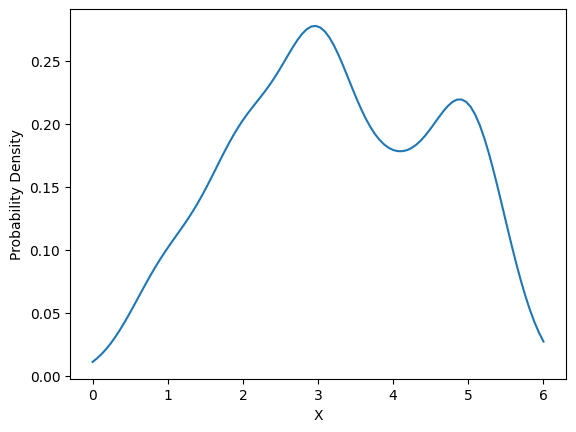

KDE Probabilities: tensor([0.1171, 0.1054])


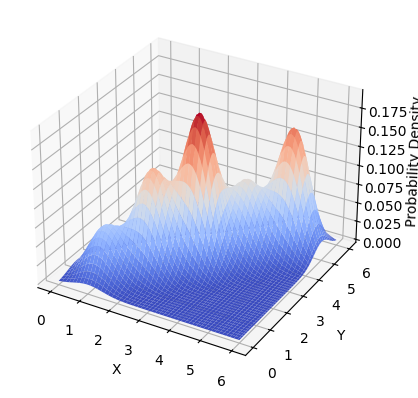

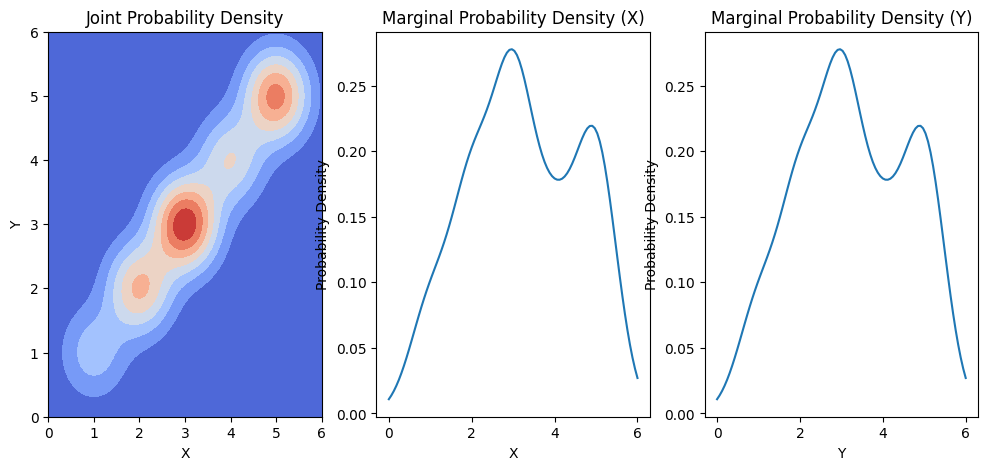

KDE Probabilities: tensor([0.0274, 0.0247])


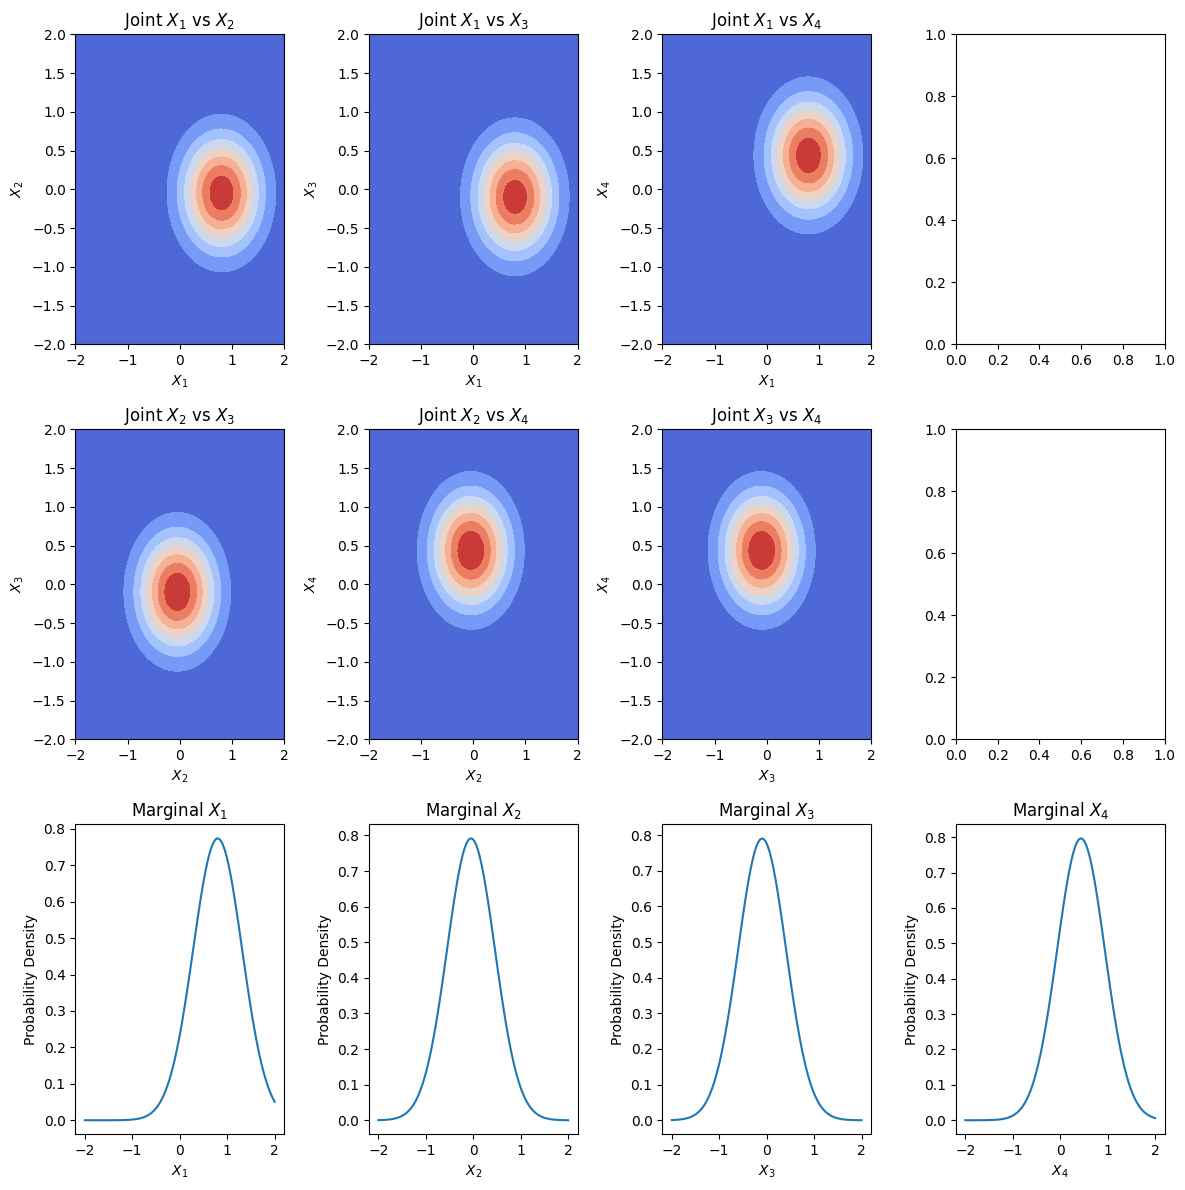

In [11]:
import torch
import matplotlib.pyplot as plt

def kde_probability(x, particles, weights, bandwidth=0.5):
    """
    Compute KDE probability for batched x values.
    
    Args:
    - x: Tensor of shape (B,) where B is the batch size.
    - particles: Tensor of shape (N,) where N is the number of particles.
    - weights: Tensor of shape (N,), should sum to 1.
    - bandwidth: Scalar, controls smoothness.
    
    Returns:
    - prob_x: Tensor of shape (B,), estimated probabilities for each x.
    """
    x = x.view(-1, 1)  # Reshape x to (B, 1)
    particles = particles.view(1, -1)  # Reshape particles to (1, N)

    # Compute Gaussian kernel values for each (x, particle) pair
    kernel_values = torch.exp(-0.5 * ((x - particles) / bandwidth) ** 2) / (bandwidth * torch.sqrt(torch.tensor(2 * torch.pi)))

    # Weighted sum over particles
    prob_x = torch.sum(weights * kernel_values, dim=1)  # Sum over N particles

    return prob_x

# Example: Batched x values
particles = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
weights = torch.tensor([0.1, 0.2, 0.3, 0.15, 0.25])  # Should sum to 1
x_values = torch.tensor([2.5, 3.5, 4.5])  # Batched x values

prob_x = kde_probability(x_values, particles, weights, bandwidth=0.5)
print("KDE Probabilities:", prob_x)


# plot for 1D
def plot_kde_1d(particles, weights, bandwidth=0.5):
    # Create a meshgrid for plotting
    x = np.linspace(0, 6, 100)
    pos = np.empty(x.shape + (1,))
    pos[:, 0] = x

    # Compute the KDE
    prob = kde_probability(torch.tensor(pos).view(-1, 1), particles, weights, bandwidth)
    prob = prob.view(100).numpy()

    # Plot the KDE
    plt.plot(x, prob)
    plt.xlabel('X')
    plt.ylabel('Probability Density')
    plt.show()

plot_kde_1d(particles, weights, bandwidth=0.5)

#####################################
# Multidimensional KDE


def kde_probability_multidim(x, particles, weights, bandwidth=0.5):
    """
    Compute KDE probability for batched multidimensional x values.

    Args:
    - x: Tensor of shape (B, d) where B is batch size, d is dimensionality.
    - particles: Tensor of shape (N, d) where N is number of particles.
    - weights: Tensor of shape (N,), should sum to 1.
    - bandwidth: Scalar, controls smoothness.

    Returns:
    - prob_x: Tensor of shape (B,), estimated probabilities for each x.
    """
    # try:
    B, d = x.shape
    # except:
    #     return kde_probability(x, particles, weights, bandwidth)
    
    N, _ = particles.shape

    # Compute Mahalanobis distance ||x - phi_i||^2 / bandwidth^2
    diff = x.unsqueeze(1) - particles.unsqueeze(0)  # Shape: (B, N, d)
    mahalanobis_dist = torch.sum((diff / bandwidth) ** 2, dim=2)  # (B, N)

    # Compute multivariate Gaussian kernel
    kernel_values = torch.exp(-0.5 * mahalanobis_dist) / ((bandwidth * torch.sqrt(torch.tensor(2 * torch.pi))) ** d)

    # Weighted sum over particles
    prob_x = torch.sum(weights * kernel_values, dim=1)  # Shape: (B,)

    return prob_x

# Example: 2D particles and batched x values
particles = torch.tensor([[1.0, 1.0], [2.0, 2.0], [3.0, 3.0], [4.0, 4.0], [5.0, 5.0]])  # (N=5, d=2)
weights = torch.tensor([0.1, 0.2, 0.3, 0.15, 0.25])  # (N,)
x_values = torch.tensor([[2.5, 2.5], [3.5, 3.5]])  # (B=2, d=2)

prob_x = kde_probability_multidim(x_values, particles, weights, bandwidth=0.5)
print("KDE Probabilities:", prob_x)

# plot the probability distribution
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_kde_2d(particles, weights, bandwidth=0.5):
    # Create a meshgrid for plotting
    x = np.linspace(0, 6, 100)
    y = np.linspace(0, 6, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    # Compute the KDE
    prob = kde_probability_multidim(torch.tensor(pos).view(-1, 2), particles, weights, bandwidth)
    prob = prob.view(100, 100).numpy()

    # Plot the KDE
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, prob, cmap=cm.coolwarm)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Probability Density')
    plt.show()

plot_kde_2d(particles, weights, bandwidth=0.5)

# plot kde for each dimension

def plot_kde_2d_marginals(particles, weights, bandwidth=0.5):
    # Create a meshgrid for plotting
    x = np.linspace(0, 6, 100)
    y = np.linspace(0, 6, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    # Compute the KDE
    prob = kde_probability_multidim(torch.tensor(pos).view(-1, 2), particles, weights, bandwidth)
    prob = prob.view(100, 100).numpy()

    # Plot the KDE
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    axs[0].contourf(X, Y, prob, cmap=cm.coolwarm)
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    axs[0].set_title('Joint Probability Density')

    # Marginalize over X
    prob_x = kde_probability(torch.tensor(x), particles[:, 0], weights, bandwidth)
    axs[1].plot(x, prob_x.numpy())
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Probability Density')
    axs[1].set_title('Marginal Probability Density (X)')

    # Marginalize over Y
    prob_y = kde_probability(torch.tensor(y), particles[:, 1], weights, bandwidth)
    axs[2].plot(y, prob_y.numpy())
    axs[2].set_xlabel('Y')
    axs[2].set_ylabel('Probability Density')
    axs[2].set_title('Marginal Probability Density (Y)')

    plt.show()

plot_kde_2d_marginals(particles, weights, bandwidth=0.5)

# plot kde for 4-dimensional particles

particles = torch.tensor([[1.0, 1.0, 1.0, 1.0], [2.0, 2.0, 2.0, 2.0], [3.0, 3.0, 3.0, 3.0], [4.0, 4.0, 4.0, 4.0], [5.0, 5.0, 5.0, 5.0]])  # (N=5, d=4)
weights = torch.tensor([0.1, 0.2, 0.3, 0.15, 0.25])  # (N,)
x_values = torch.tensor([[2.5, 2.5, 2.5, 2.5], [3.5, 3.5, 3.5, 3.5]])  # (B=2, d=4)

prob_x = kde_probability_multidim(x_values, particles, weights, bandwidth=0.5)
print("KDE Probabilities:", prob_x)

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_kde_4d_marginals(particles, weights, bandwidth=0.1):
    """
    Plot KDE-based joint and marginal probability densities for a 4D particle distribution.

    Args:
    - particles: Tensor of shape (N, 4) containing particle states.
    - weights: Tensor of shape (N,), importance weights.
    - bandwidth: Float, controls KDE smoothness.

    Outputs:
    - 3x3 grid: 2D KDE plots for joint distributions and 1D KDE plots for marginals.
    """
    # Define the plotting range
    x = torch.linspace(-2, 2, 100)
    y = torch.linspace(-2, 2, 100)
    X, Y = torch.meshgrid(x, y, indexing="ij")  # Proper indexing
    pos = torch.stack([X, Y], dim=-1).reshape(-1, 2)  # Shape: (10000, 2)

    fig, axs = plt.subplots(3, 4, figsize=(12, 12))
    dim_labels = [f"$X_{i+1}$" for i in range(4)]
    pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

    for idx, (i, j) in enumerate(pairs):
        row, col = divmod(idx, 3)

        # Compute the KDE for joint distributions (keep tensors)
        prob = kde_probability_multidim(pos, particles[:, [i, j]], weights, bandwidth)
        prob = prob.view(100, 100).numpy()  # Convert only at the end

        # Plot joint probability density
        axs[row, col].contourf(X.numpy(), Y.numpy(), prob, cmap=cm.coolwarm)
        axs[row, col].set_xlabel(dim_labels[i])
        axs[row, col].set_ylabel(dim_labels[j])
        axs[row, col].set_title(f"Joint {dim_labels[i]} vs {dim_labels[j]}")

    # Marginal plots (last row)
    for k in range(4):
        prob_k = kde_probability(x, particles[:, k], weights, bandwidth)  # Keep tensors
        axs[2, k].plot(x.numpy(), prob_k.numpy())  # Convert at the end
        axs[2, k].set_xlabel(dim_labels[k])
        axs[2, k].set_ylabel("Probability Density")
        axs[2, k].set_title(f"Marginal {dim_labels[k]}")

    plt.tight_layout()
    plt.show()

# Example: 4D Gaussian particles with weights
# N = 1000
# particles = torch.randn(N, 4)  # Sample 4D Gaussian particles
# weights = torch.softmax(torch.randn(N), dim=0)  # Random normalized weights

particles = agent.PF.particles.detach()
weights = agent.PF.weights.detach()

# Plot 4D KDE-based distributions
plot_kde_4d_marginals(particles, weights, bandwidth=0.5)



In [19]:
from torch.distributions.beta import Beta

# Convert to log-space to prevent NaNs when taking log(0)
particles = particles.clamp(1e-5, 1 - 1e-5)

# Initialize alpha and beta (avoid zero values)
alpha = torch.tensor(1.0, requires_grad=True)
beta = torch.tensor(1.0, requires_grad=True)

optimizer = torch.optim.Adam([alpha, beta], lr=0.1)

# Negative log-likelihood function
def negative_log_likelihood():
    dist = Beta(alpha, beta)
    log_probs = dist.log_prob(particles)
    weighted_log_likelihood = torch.sum(weights * log_probs)  # Weighted sum
    return -weighted_log_likelihood  # Minimize negative likelihood

# Optimization loop
for step in range(500):  # Adjust iterations as needed
    optimizer.zero_grad()
    loss = negative_log_likelihood()
    loss.backward()
    optimizer.step()
    
    # Ensure parameters stay positive
    with torch.no_grad():
        alpha.clamp_(1e-5, None)
        beta.clamp_(1e-5, None)

print(f"MLE: alpha={alpha.item()}, beta={beta.item()}")


RuntimeError: The size of tensor a (4000) must match the size of tensor b (4) at non-singleton dimension 1

In [38]:
import torch

# Example particles and weights (ensure particles are in (0,1))
# particles = torch.tensor([0.2, 0.5, 0.8, 0.1], dtype=torch.float32)
# weights = torch.tensor([0.1, 0.4, 0.3, 0.2], dtype=torch.float32)  # Must sum to 1

particles = agent.PF.particles.detach()
weights = agent.PF.weights.detach()

# Compute weighted mean and variance
mu_w = torch.sum(weights.unsqueeze(1) * particles, dim=0)
sigma2_w = torch.sum(weights.unsqueeze(1) * (particles - mu_w) ** 2, dim=0)

# Method of Moments estimation
alpha = mu_w * ((mu_w * (1 - mu_w)) / sigma2_w - 1)
beta = (1 - mu_w) * ((mu_w * (1 - mu_w)) / sigma2_w - 1)

print(f"Method of Moments: alpha={alpha}, beta={beta}")


Method of Moments: alpha=tensor([84.7157,  0.1167,  0.2956,  5.0706]), beta=tensor([32.9478, -4.2598, -6.4456,  1.9388])


In [41]:
weights.shape, particles.shape

(torch.Size([1000]), torch.Size([1000, 4]))

In [47]:
torch.einsum('i,ij->j', weights, particles)

tensor([ 0.7200, -0.0282, -0.0481,  0.7234])

In [48]:
(weights.unsqueeze(1) * particles).sum(dim=0)

tensor([ 0.7200, -0.0282, -0.0481,  0.7234])

/tmp/ipykernel_11860/1563162469.py:7: RuntimeWarning: divide by zero encountered in power
  y = x ** (alpha - 1) * (1 - x) ** (beta - 1)
/tmp/ipykernel_11860/1563162469.py:8: RuntimeWarning: invalid value encountered in divide
  y /= np.trapz(y, x)  # Normalize the distribution


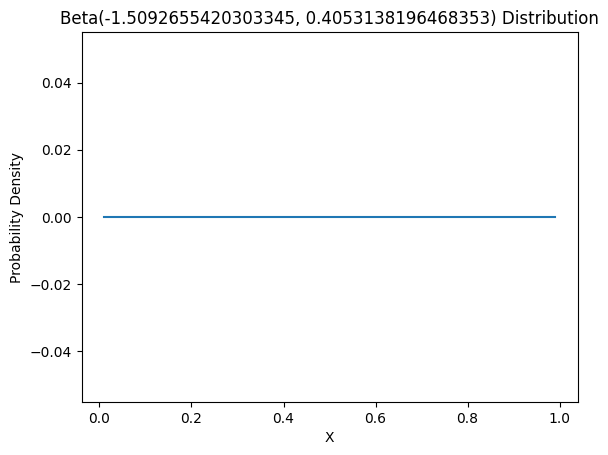

In [33]:
# plot the beta probability distribution
import numpy as np
import matplotlib.pyplot as plt

def plot_beta_distribution(alpha, beta):
    x = np.linspace(0, 1, 100)
    y = x ** (alpha - 1) * (1 - x) ** (beta - 1)
    y /= np.trapz(y, x)  # Normalize the distribution

    plt.plot(x, y)
    plt.xlabel("X")
    plt.ylabel("Probability Density")
    plt.title(f"Beta({alpha}, {beta}) Distribution")
    plt.show()

# Example: Plot Beta(2, 2) distribution
plot_beta_distribution(alpha.detach().numpy(), beta.detach().numpy())

# videorecording

In [7]:
import gymnasium as gym
import os
import numpy as np
import pygame
import cv2
from datetime import datetime

class SimpleVideoRecorder(gym.Wrapper):
    """
    A simpler video recording wrapper that doesn't rely on Gymnasium's RecordVideo.
    It directly captures frames from Pygame and saves them using OpenCV.
    """
    def __init__(
        self,
        env,
        video_folder="videos",
        name_prefix="pomdp_gridworld",
        fps=30,
        record_every_episode=True
    ):
        super().__init__(env)
        self.video_folder = video_folder
        self.name_prefix = name_prefix
        self.fps = fps
        self.record_every_episode = record_every_episode
        self.episode_id = 0
        self.recording = False
        self.frames = []
        
        # Create video folder if it doesn't exist
        os.makedirs(video_folder, exist_ok=True)
        
    def reset(self, **kwargs):
        """Reset the environment and start recording if needed."""
        self.episode_id += 1
        self.frames = []
        self.recording = self.record_every_episode or (self.episode_id % 5 == 0)  # Record every 5th episode if not recording all
        
        # Call the environment's reset
        observation, info = self.env.reset(**kwargs)
        
        # Capture the initial frame
        if self.recording:
            self._capture_frame()
            
        return observation, info
    
    def step(self, action):
        """Take a step and capture a frame if recording."""
        # Call the environment's step method
        observation, reward, terminated, truncated, info = self.env.step(action)
        
        # Capture frame if recording
        if self.recording:
            self._capture_frame()
            
        # Save video when episode ends
        if self.recording and (terminated or truncated):
            self._save_video()
            self.recording = False
            
        return observation, reward, terminated, truncated, info
    
    def _capture_frame(self):
        """Capture the current frame from Pygame surface."""
        if hasattr(self.env, "screen"):
            # Get the screen data
            screen_data = pygame.surfarray.array3d(self.env.screen)
            # Convert from (width, height, channel) to (height, width, channel)
            screen_data = screen_data.transpose((1, 0, 2))
            # Convert from RGB to BGR (for OpenCV)
            screen_data = screen_data[:, :, ::-1]
            self.frames.append(screen_data)
    
    def _save_video(self):
        """Save the recorded frames as a video."""
        if not self.frames:
            return
            
        # Generate a filename with timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        video_path = os.path.join(
            self.video_folder,
            f"{self.name_prefix}_episode_{self.episode_id}_{timestamp}.mp4"
        )
        
        # Get frame dimensions
        height, width, _ = self.frames[0].shape
        
        # Create a video writer
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        video_writer = cv2.VideoWriter(video_path, fourcc, self.fps, (width, height))
        
        # Write frames to video
        for frame in self.frames:
            video_writer.write(frame)
            
        # Release the video writer
        video_writer.release()
        
        print(f"Video saved to {video_path}")

In [15]:
import os
import pygame
from datetime import datetime

def main():
    # Create your POMDPDeformedGridworld environment
    env = POMDPDeformedGridworld(render_mode='human', obs_type='cardinal')
    env.render_bis()
    agent = POMDPAgent(model, env, update=BELIEF_UPDATE, obs_model=obs_model,discretization=DISCRETIZATION, debug=DEBUG)
    
    # Set up the simple video recording wrapper
    video_folder = os.path.join(os.getcwd(), "videos")
    
    # Generate a unique name prefix using timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    name_prefix = f"pomdp_gridworld_{timestamp}"
    
    # Wrap the environment with the simple video recorder
    env = SimpleVideoRecorder(
        env=env,
        video_folder=video_folder,
        name_prefix=name_prefix,
        fps=30,
        record_every_episode=True
    )

    # Number of episodes to record
    num_episodes = 3
    
    for episode in range(num_episodes):
        print(f"Recording episode {episode+1}/{num_episodes}")
        
        # Reset the environment at the beginning of each episode
        state, _ = env.reset()
        episode_reward = 0
        done = False
        step_count = 0
        
        while not done:
            # Use random actions for demonstration
            action, _  = agent.predict(env.env.get_state(), deterministic=False)

            # Take a step in the environment
            next_state, reward, terminated, truncated, info = env.step(action)
            
            # Update state and check if episode is done
            state = next_state
            done = terminated or truncated
            episode_reward += reward
            step_count += 1
            
            # Optional: Add a delay to make the video slower and more viewable
            pygame.time.delay(50)  # 50ms delay
        
        
        print(f"Episode {episode+1} completed with reward {episode_reward} in {step_count} steps")
    
    # Close the environment when done
    env.close()
    print(f"All episodes recorded. Videos saved to {video_folder}")

if __name__ == "__main__":
    main()

Recording episode 1/3
Video saved to /home/flaccagora/Desktop/RoboSurgery/src/test/continous_tests/videos/pomdp_gridworld_20250307_201452_episode_1_20250307_201458.mp4
Episode 1 completed with reward -23.0 in 49 steps
Recording episode 2/3
Video saved to /home/flaccagora/Desktop/RoboSurgery/src/test/continous_tests/videos/pomdp_gridworld_20250307_201452_episode_2_20250307_201504.mp4
Episode 2 completed with reward -23.0 in 43 steps
Recording episode 3/3
Video saved to /home/flaccagora/Desktop/RoboSurgery/src/test/continous_tests/videos/pomdp_gridworld_20250307_201452_episode_3_20250307_201505.mp4
Episode 3 completed with reward -2.0 in 7 steps
All episodes recorded. Videos saved to /home/flaccagora/Desktop/RoboSurgery/src/test/continous_tests/videos


# MDP bound

In [8]:
from tqdm import trange 
def eval_agent_mdp(agent,env,num_episodes):
    """Returns
        - episode_transition: list of list of tuples (s,a,r,s',done), t[i] is the ith episode
        - beliefs: list of beliefs at each time step 
    """
    transitions = []
    for i in trange(num_episodes):
        s, _ = env.reset()

        totalReward = 0.0
        done = False
        steps = 0

        ep_transitions = []

        while not done:
            best_action, _ = agent.predict(s,deterministic=True)
            next_state, reward, terminated, truncated, info = env.step(best_action)
            
            # torch_dict = {key: torch.tensor(val, dtype=torch.float32).unsqueeze(0).to(agent.device) for key, val in next_state.items()}
            # value = agent.policy.predict_values(torch_dict)        
            # print(value)
            totalReward += reward            

            done = terminated or truncated
            s = next_state
            steps += 1

            ep_transitions.append((s, best_action, reward, next_state, terminated, truncated))
            # time.sleep(0.05)
    
        transitions.append(ep_transitions)

    env.close()

    return transitions

env = Grid(
    render_mode="rgb_array",
    step_size=0.01,
)

transitions = eval_agent_mdp(model,env,10000)

100%|██████████| 10000/10000 [02:18<00:00, 72.00it/s]


In [11]:
# chek how many times the agent has reached the goal
reached_goal = 0
for ep in transitions:
    if ep[-1][-2] == True:
        reached_goal += 1
print("Target reached", reached_goal, "out of", len(transitions), "episodes")    

# check the mean reward
mean_reward = 0
for ep in transitions:
    mean_reward += sum([t[2] for t in ep])
mean_reward /= len(transitions)
print("Mean episode Reward: ", mean_reward)

# check the mean number of steps
mean_steps = 0
for ep in transitions:
    mean_steps += len(ep)
mean_steps /= len(transitions)
print("Mean number of steps: ", mean_steps)

Target reached 9966 out of 10000 episodes
Mean episode Reward:  -14.2721
Mean number of steps:  28.126


# EVALUATION

In [8]:
from tqdm import trange

def eval_agent_pomdp(agent:POMDPAgent,env: POMDPDeformedGridworld,num_episodes):
    """Returns
        - episode_transition: list of list of tuples (s,a,r,s',done), t[i] is the ith episode
        - beliefs: list of beliefs at each time step 
    """

    assert agent.debug, 'Agent must be in debug mode to evaluate'

    transitions = []
    entropy = []

    for i in trange(num_episodes):

        agent.reset()
        s, _ = env.reset()

        totalReward = 0.0
        done = False
        steps = 0
        episode_transitions = []
        episode_entropy = []
        
        while not done:

            best_action, _ = agent.predict(s, deterministic=True)

            next_state, reward, terminated, truncated, info = env.step(best_action)
            
            done = terminated or truncated
            s = next_state

            steps += 1
            totalReward += reward
            episode_transitions.append((s, best_action, reward, next_state, terminated, truncated))
            episode_entropy.append(agent.entropy.item())

        transitions.append(episode_transitions)
        entropy.append(episode_entropy)

    env.close()

    return transitions, entropy


In [9]:
OBSERVATION_TYPE = 'cardinal' # 'single' or 'cardinal' 
RENDER_MODE = 'rgb_array' # 'rgb_array' or 'human'
BELIEF_UPDATE = 'particlefilters' # 'variational' 'discrete' or 'particlefilters'
DISCRETIZATION = 2000
DEBUG = True

obs_model = load_obs_model(OBSERVATION_TYPE)

In [10]:
# pomdp_env = POMDPDeformedGridworld(obs_type=OBSERVATION_TYPE, render_mode=RENDER_MODE)
# agent = POMDPAgent(model, pomdp_env, update=BELIEF_UPDATE, obs_model=obs_model,discretization=DISCRETIZATION, debug=DEBUG)
# transitions_ts, entropy_ts = eval_agent_pomdp(agent,pomdp_env, 1000)

agent = MLSAgent(model, pomdp_env, update=BELIEF_UPDATE, obs_model=obs_model,discretization=DISCRETIZATION, debug=DEBUG)
transitions_mls, entropy_mls = eval_agent_pomdp(agent,pomdp_env, 1000)

Using particlefilters belief update method


  2%|▏         | 18/1000 [00:02<01:52,  8.73it/s]


KeyboardInterrupt: 

In [57]:
def explain_transitions(transitions):
    # chek how many times the agent has reached the goal
    reached_goal = 0
    for ep in transitions:
        if ep[-1][-2] == True:
            reached_goal += 1
    print("Target reached", reached_goal, "out of", len(transitions), "episodes")    

    # check the mean reward
    mean_reward = 0
    for ep in transitions:
        mean_reward += sum([t[2] for t in ep])
    mean_reward /= len(transitions)
    print("Mean episode Reward: ", mean_reward)

    # check the mean number of steps
    mean_steps = 0
    for ep in transitions:
        mean_steps += len(ep)
    mean_steps /= len(transitions)
    print("Mean number of steps: ", mean_steps)

def evaluate_statistics(transitions):
    """
    Evaluate statistics from transitions data organized as transitions[episode][step].
    
    Parameters:
    transitions: list of lists, where transitions[episode][step] contains
                a tuple (s, best_action, reward, next_state, terminated, truncated)
    
    Returns:
    dict with statistics including:
    - mean_episode_reward: Mean reward per episode
    - std_episode_reward: Standard deviation of rewards per episode
    - mean_episode_steps: Mean number of steps per episode
    - std_episode_steps: Standard deviation of steps per episode
    - terminated_episodes: Number of episodes that terminated naturally
    - truncated_episodes: Number of episodes that were truncated
    """
    episode_rewards = []
    episode_steps = []
    terminated_count = 0
    truncated_count = 0
    
    # Process each episode
    for episode_transitions in transitions:
        total_reward = 0
        num_steps = len(episode_transitions)
        
        # Check the final transition to determine if episode terminated or truncated
        if num_steps > 0:
            final_transition = episode_transitions[-1]
            s, action, reward, next_s, terminated, truncated = final_transition
            
            if terminated:
                terminated_count += 1
            if truncated:
                truncated_count += 1
        
        # Calculate total reward for the episode
        for step in range(num_steps):
            s, action, reward, next_s, terminated, truncated = episode_transitions[step]
            total_reward += reward
        
        # Record stats for this episode
        episode_rewards.append(total_reward)
        episode_steps.append(num_steps)
    
    # Calculate statistics
    stats = {
        'mean_episode_reward': np.mean(episode_rewards) if episode_rewards else 0,
        'std_episode_reward': np.std(episode_rewards) if episode_rewards else 0,
        'mean_episode_steps': np.mean(episode_steps) if episode_steps else 0,
        'std_episode_steps': np.std(episode_steps) if episode_steps else 0,
        'num_episodes': len(episode_rewards),
        'terminated_episodes': terminated_count,
        'truncated_episodes': truncated_count,
        'termination_rate': terminated_count / len(episode_rewards) if episode_rewards else 0,
        'truncation_rate': truncated_count / len(episode_rewards) if episode_rewards else 0
    }
    
    return stats


explain_transitions(transitions_mls)

evaluate_statistics(transitions_mls)

Target reached 964 out of 1000 episodes
Mean episode Reward:  -39.5455
Mean number of steps:  49.064


{'mean_episode_reward': -39.5455,
 'std_episode_reward': 139.42703891193415,
 'mean_episode_steps': 49.064,
 'std_episode_steps': 89.64038098981953,
 'num_episodes': 1000,
 'terminated_episodes': 964,
 'truncated_episodes': 36,
 'termination_rate': 0.964,
 'truncation_rate': 0.036}

In [55]:
transitions_mls[2][8]

({'obs': tensor([0., 0., 0., 0.]), 'pos': tensor([0.2800, 0.2743])},
 array(2),
 -0.5,
 {'obs': tensor([0., 0., 0., 0.]), 'pos': tensor([0.2800, 0.2743])},
 False,
 False)

In [29]:
explain_transitions(transitions_ts)

Target reached 994 out of 1000 episodes
Mean episode Reward:  -30.338
Mean number of steps:  45.469


In [ ]:
def plot_entropy(entropy):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,6))
    for i in range(len(entropy)):
        plt.plot(entropy[i])

    plt.xlabel('Time step')
    plt.ylabel('Entropy')
    plt.title('Entropy over time')

plot_entropy(entropy)

In [171]:
reached_goal = 0
truncated_index = []
for i, ep in enumerate(transitions):
    if ep[-1][-2] == True:
        reached_goal += 1
    else:
        truncated_index.append(i)
print("Target reached", reached_goal, "out of", len(transitions), "episodes")    

# check the mean reward
mean_reward = 0
for i, ep in enumerate(transitions):
    if i in truncated_index:
        continue
    mean_reward += sum([t[2] for t in ep])
mean_reward /= len(transitions)
print("Mean episode Reward: ", mean_reward)

# check the mean number of steps
mean_steps = 0
for i, ep in enumerate(transitions):
    if i in truncated_index:
        continue
    mean_steps += len(ep)
mean_steps /= len(transitions)
print("Mean number of steps: ", mean_steps)


NameError: name 'transitions' is not defined

# Discrete vs VI

In [ ]:
OBSERVATION_TYPE = 'single' # OR 'cardinal'
RENDER_MODE = 'human' # OR 'rgb_array'
BELIEF_UPDATE = 'discrete' # OR 'variational'
DISCRETIZATION = 20
DEBUG = True

obs_model = load_obs_model(OBSERVATION_TYPE)

pomdp_env = POMDPDeformedGridworld(obs_type=OBSERVATION_TYPE, render_mode=RENDER_MODE)
agent = POMDPAgent(model, pomdp_env, update=BELIEF_UPDATE, obs_model=obs_model,discretization=DISCRETIZATION, debug=DEBUG)


In [ ]:
pomdp_env.reset()

stretch, shear = [pomdp_env.transformation_matrix[0][0], pomdp_env.transformation_matrix[1][1]],[pomdp_env.transformation_matrix[0][1], pomdp_env.transformation_matrix[1][0]]
starting_pos = pomdp_env.get_state()['pos']

print("Starting position: ", starting_pos)
print("Deformation: ", pomdp_env.transformation_matrix)

In [168]:
while True:
    try:
        action, _  = agent.predict(pomdp_env.get_state(), deterministic=False)
        _, _ , terminated, truncated, _ = pomdp_env.step(action)
        pomdp_env.render()
        if terminated or truncated:
            break
    except:
        break
pomdp_env.close()   

In [ ]:
OBSERVATION_TYPE = 'single' # OR 'cardinal'
RENDER_MODE = 'human' # OR 'rgb_array'
BELIEF_UPDATE = 'variational' # OR 'variational'
DISCRETIZATION = 20
DEBUG = True

obs_model = load_obs_model(OBSERVATION_TYPE)

pomdp_env = POMDPDeformedGridworld(obs_type=OBSERVATION_TYPE, render_mode=RENDER_MODE)
agent = POMDPAgent(model, pomdp_env, update=BELIEF_UPDATE, obs_model=obs_model,discretization=DISCRETIZATION, debug=DEBUG)


In [170]:
pomdp_env.set_deformation(stretch, shear)
pomdp_env.set_position(starting_pos.tolist())

In [ ]:
while True:
    try:
        action, _  = agent.predict(pomdp_env.get_state(), deterministic=False)
        _, _ , terminated, truncated, _ = pomdp_env.step(action)
        pomdp_env.render()
        if terminated or truncated:
            break
    except:
        break
pomdp_env.close()   

# agents

In [5]:
import torch
import numpy as np
from collections import OrderedDict
from stable_baselines3 import PPO

class POMDPAgent():
    
    def __init__(self,mdp_agent:PPO, pomdp_env: POMDPDeformedGridworld, discretization=10, update='discrete', obs_model=None, debug=False):
        assert isinstance(pomdp_env, POMDPDeformedGridworld), f'Invalid environment type {type(pomdp_env)}'
        self.pomdp_env = pomdp_env
        self.mdp_agent = mdp_agent
        self.update = update

        if update == 'discrete' or update == 'discrete_exact':
            stretch = np.linspace(.4, 1, discretization)
            shear = np.linspace(-.2,.2, discretization)
            xa,ya,yb,xb = np.meshgrid(stretch, shear,shear,stretch) # , shear, shear
            positions = np.column_stack([xa.ravel(),ya.ravel(),yb.ravel(),xb.ravel()]),
            positions = torch.tensor(np.array(positions), dtype=torch.float32)
            self.belief_points = positions.squeeze()
            self.belief_values = torch.ones(self.belief_points.shape[0], dtype=torch.float32, requires_grad=False) / len(positions)
            
            self.original_def = env.transformation_matrix[0][0], env.transformation_matrix[1][1]

        if update == 'discrete': 
            assert obs_model is not None, f'Need an observation model for discrete belief update, given {obs_model}'
            self.obs_model = obs_model
            self.belief_update = self.discrete_belief_update
            print('Discrete belief update with observation model - SHEAR allowed')
        elif update == 'discrete_exact':
            self.belief_update = self.exact_belief_update
            raise NotImplementedError('Exact belief update not implemented here')
        elif update == 'variational':
            from utils.belief import BetaVariationalBayesianInference
            assert obs_model is not None, f'Need an observation model for variational belief update, given {obs_model}'
            self.VI = BetaVariationalBayesianInference(obs_model, input_dim=2, latent_dim=4, debug=debug)
            self.obs_model = obs_model

            self.belief_update = self.variational_belief_update
            self.X_history = [self.pomdp_env.get_state()['pos']]
            self.y_history = [self.pomdp_env.get_state()['obs']]
        elif update == 'particlefilters':
            from utils.belief import BayesianParticleFilter
            self.obs_model = obs_model
            self.n_particles = discretization
            self.PF = BayesianParticleFilter(f = obs_model, n_particles=self.n_particles, theta_dim=4)
            self.belief_points, self.belief_values = self.PF.initialize_particles()
            self.belief_update = self.particle_filter_belief_update
            
            self.X_history = [self.pomdp_env.get_state()['pos']]
            self.y_history = [self.pomdp_env.get_state()['obs']]

        else:
            raise ValueError('Invalid belief update method')
        
        self.debug = debug
        if self.debug:
            print(f'Using {update} belief update method')
    
    def predict(self, s, deterministic=True):
        
        self.belief_update(s)
        pos = s['pos']
        if self.update == 'discrete_exact' or self.update == 'discrete':
            # theta = self.belief_points[self.belief_values.argmax()] # QMDP
            theta = self.belief_points[torch.multinomial(self.belief_values, 1).item()] #  sampling
        elif self.update == 'variational':
            theta = self.VI.sample_latent(1).squeeze().clone().detach().numpy() # variational sampling
        elif self.update == 'particlefilters':
            mean, var = self.PF.estimate_posterior()
            theta = torch.distributions.Normal(torch.tensor(mean), torch.tensor(var).sqrt()+1e-6).sample().squeeze()
            # theta = torch.tensor(mean, dtype=torch.float32)

        s = OrderedDict({'pos': pos, 'theta': theta})
        action = self.mdp_agent.predict(s, deterministic=deterministic)

        self.on_precidt_callback()
        return action
    
    def discrete_belief_update(self, pomdp_state):
        """discrete belief update"""
        pos = pomdp_state['pos']
        obs = pomdp_state['obs']

        batch_pos = pos.repeat(len(self.belief_points), 1)

        model_device = next(self.obs_model.parameters()).device
        with torch.no_grad():
            predictions = self.obs_model(batch_pos.to(model_device),self.belief_points.to(model_device))

        likelihood = torch.distributions.Bernoulli(predictions).log_prob(obs.to(model_device))
        if len(likelihood.shape) == 2:
            likelihood = likelihood.sum(dim=1)
        likelihood = likelihood.exp()

        tmp = likelihood.squeeze() * self.belief_values.to(model_device)
        self.belief_values = tmp  / tmp.sum()

    def exact_belief_update(self, pomdp_state):
        """discrete belief update"""
        obs = pomdp_state['obs']
        pos = pomdp_state['pos']

        def f():
            likelihood = []
            for x in self.belief_points:
                try:
                    self.pomdp_env.set_deformation([x[0], x[1]],[0,0]) # stretch, shear format
                    likelihood.append(torch.all(torch.tensor(self.pomdp_env.observe(list(pos))) == obs))
                except:
                    raise ValueError('Invalid belief point x', x)
            self.pomdp_env.set_deformation(self.original_def, [0,0])
            return torch.tensor(likelihood, dtype=torch.float32)

        
        likelihood = f()
        self.belief_values =  likelihood * self.belief_values
        self.belief_values = self.belief_values / self.belief_values.sum()

    def variational_belief_update(self, pomdp_state):
        self.X_history.append(pomdp_state['pos'])
        self.y_history.append(pomdp_state['obs'])

        # X = posizione dell'agente (x,y)
        X = torch.stack(self.X_history)

        # ossevrazioni dell'agente negli stati pos=(x,y)
        y = torch.stack(self.y_history)

        # Create and fit the model
        self.VI.fit(X, y, n_epochs=10, lr=0.05)

    def particle_filter_belief_update(self, pomdp_state):
        self.X_history.append(pomdp_state['pos'])
        self.y_history.append(pomdp_state['obs'])

        # X = posizione dell'agente (x,y)
        X = torch.stack(self.X_history[-1:])

        # ossevrazioni dell'agente negli stati pos=(x,y)
        y = torch.stack(self.y_history[-1:])

        # X, y = pomdp_state['pos'].unsqueeze(0), pomdp_state['obs'].unsqueeze(0)

        # Create and fit the model
        self.belief_points, self.belief_values = self.PF.update(X, y)

    def on_precidt_callback(self):
        if self.debug:
            self.print_stats()
        
    def print_stats(self):
        if self.update == 'discrete':
            # print(f'Belief shape: {self.belief_values.shape}')
            # print(f'Belief points shape: {self.belief_points.shape}')
            # print(f'Belief max: {self.belief_points[self.belief_values.argmax()]}')
            # print(f'Belief sum: {self.belief_values.sum()}')
            # print(f'Belief entropy: {torch.distributions.Categorical(probs=self.belief_values).entropy()}')
            # print("\n")
            self.entropy = torch.distributions.Categorical(probs=self.belief_values).entropy()
        elif self.update == 'variational':
            # print(f'Variational inference: {self.VI.entropy()}')
            # print(self.VI.get_posterior_params())
            # print("\n")
            self.entropy = self.VI.entropy()
        elif self.update == 'particlefilters':
            # print(f'Particle filter: {self.PF.estimate_posterior()[1]}')
            # print("\n")
            self.entropy = self.PF.entropy()
        
    def reset(self):
        self.X_history = [self.pomdp_env.get_state()['pos']]
        self.y_history = [self.pomdp_env.get_state()['obs']]
        self.entropy = None

        if self.update == 'discrete':
            self.belief_values = torch.ones(self.belief_points.shape[0], dtype=torch.float32, requires_grad=False) / len(self.belief_points)
        elif self.update == 'variational':
            del self.VI
            from utils.belief import BetaVariationalBayesianInference
            self.VI = BetaVariationalBayesianInference(self.obs_model, input_dim=2, latent_dim=4, debug=self.debug)
        elif self.update == 'particlefilters':
            del self.PF
            from utils.belief import BayesianParticleFilter
            self.PF = BayesianParticleFilter(f = self.obs_model, n_particles=self.n_particles, theta_dim=4)
            self.PF.initialize_particles()

In [ ]:
class QMDP_Value(POMDPAgent):
    def __init__(self,mdp_agent:PPO, pomdp_env: POMDPDeformedGridworld, discretization=10, update='discrete', obs_model=None, debug=False):
        super().__init__(mdp_agent, pomdp_env, discretization, update, obs_model, debug)

        self.V = mdp_agent.policy.predict_values
        self.pomdp_env_bis = POMDPDeformedGridworld(obs_type=OBSERVATION_TYPE, render_mode='rgb_array')
        self.obs_model.to(self.mdp_agent.device)

        if update == 'particlefilters':
            self.belief_points = self.PF.particles
            self.belief_values = self.PF.weights

    def predict_simple(self, s, deterministic=True):
        """
            \pi(b) = argmax_a \sum_{s'} P(s'|s,a) \sum_{o} P(o|s',a) b(s')
                   = argmax_a \sum_{s} b(s) * Q(s,a)
                   = argmax_a \sum_{s} b(s) * [R(s,a) + \gamma \sum_{o} P(o|s',a) V(s')]
                   = argmax_a \sum_{s} b(s) * [R(s,a) + \gamma p(o|s',a) * V(s')]
                   = argmax_a \sum_{\theta} b(theta) * [R((pos,theta),a) + \gamma p(o|(pos',theta),a) * V((pos',theta))]

            sommo su theta, la posizione è fissa
        """
        self.belief_update(s)

        def R_s_a(s,a):
            self.pomdp_env_bis.set_position(self.pomdp_env.get_state()['pos'].tolist())
            self.pomdp_env_bis.set_deformation([s['theta'][0], s['theta'][3]],[s['theta'][1], s['theta'][2]])
            next_obs_pos, R_s_a, _, _, _ = self.pomdp_env_bis.step(a)

            # print(R_s_a, next_obs_pos['pos'])
            return R_s_a, next_obs_pos['pos'], next_obs_pos['obs']
        
        def P_o_s(o,s):
            with torch.no_grad():
                # print(s['pos'].to(self.mdp_agent.device), s['theta'].to(self.mdp_agent.device))
                predicted = self.obs_model(s['pos'].to(self.mdp_agent.device),s['theta'].to(self.mdp_agent.device))
            
            likelihood = torch.distributions.Bernoulli(predicted).log_prob(o.to(self.mdp_agent.device))
            if len(likelihood.shape) == 2:
                likelihood = likelihood.sum(dim=1)

            return likelihood.exp().item()

        def Q_s_a(s,a):
            R, next_pos, next_obs = R_s_a(s,a)

            s = {'pos': next_pos.unsqueeze(0), 
                        'theta': s['theta'].unsqueeze(0)}
            
            V = self.V({'pos': next_pos.unsqueeze(0).to(self.mdp_agent.device), 
                        'theta': s['theta'].unsqueeze(0).to(self.mdp_agent.device)}).item()

            # assert 1 >= P_o_s(next_obs, s) > 0, f'Invalid observation model {P_o_s(next_obs, s)}'
            # print(P_o_s(next_obs, s).device)
            #  P_o_s(next_obs, s) * do not use p_o_s
            qsa =  R + 0.95 * V
            # print(qsa.device)
            # print("QSA", qsa)
            return qsa

        qmdp = torch.zeros((4,)).to(self.mdp_agent.device)
        for t, theta in enumerate(self.belief_points):
            for a in range(4):
                qsa = Q_s_a({'pos': s['pos'], 'theta': theta}, a)
                qmdp[a] += (self.belief_values[t] * qsa)

        return torch.argmax(qmdp).item(), qmdp           

    def predict(self, s, deterministic=True):
        """
        Parallelized version of the predict function that computes Q-values for all belief points and actions simultaneously.
        
        Args:
            s: Current state containing position and observation
            deterministic: Whether to use deterministic policy (default: True)
        
        Returns:
            Optimal action and Q-values for all actions
        """

        self.belief_update(s)

        # Set position once
        self.pomdp_env_bis.set_position(s['pos'].tolist())
        
        # Move belief points to device if needed
        belief_points = self.belief_points.to(self.mdp_agent.device)
        belief_values = self.belief_values.to(self.mdp_agent.device)
        
        # Pre-allocate tensors for results
        num_belief_points = belief_points.shape[0]
        num_actions = 4
        all_rewards = torch.zeros((num_belief_points, num_actions), device=self.mdp_agent.device)
        all_next_positions = torch.zeros((num_belief_points, num_actions, s['pos'].shape[0]), device=self.mdp_agent.device)
        all_next_observations = []
        
        # Step 1: Compute rewards and next states for all belief points and actions
        for t in range(num_belief_points):
            theta = belief_points[t]
            # Set deformation once per theta
            self.pomdp_env_bis.set_position(self.pomdp_env.get_state()['pos'].tolist())
            self.pomdp_env_bis.set_deformation([theta[0], theta[3]], [theta[1], theta[2]])
            
            for a in range(num_actions):
                next_obs_pos, reward, _, _, _ = self.pomdp_env_bis.step(a)
                all_rewards[t, a] = reward
                all_next_positions[t, a] = next_obs_pos['pos']
                all_next_observations.append(next_obs_pos['obs'])
                self.pomdp_env_bis.set_position(self.pomdp_env.get_state()['pos'].tolist())
        
        # Reshape observations into proper tensor
        all_next_observations = torch.stack(all_next_observations).reshape(num_belief_points, num_actions, -1)
        
        # Step 2: Compute V(s') for all next states in parallel
        # Prepare batched states for value function
        batched_next_states = {
            'pos': all_next_positions.view(num_belief_points * num_actions, -1).to(self.mdp_agent.device),
            'theta': belief_points.repeat_interleave(num_actions, dim=0).to(self.mdp_agent.device)
        }
        
        # Get values for all next states in one batch
        next_values = self.V(batched_next_states).view(num_belief_points, num_actions)
        
        # Step 3: Compute observation probabilities in parallel
        # with torch.no_grad():
        #     # Prepare inputs for the observation model
        #     batched_positions = all_next_positions.view(num_belief_points * num_actions, -1)
        #     batched_thetas = belief_points.repeat_interleave(num_actions, dim=0)
            
        #     # Get predicted observations for all states in one batch
        #     predicted_obs = self.obs_model(batched_positions, batched_thetas)
            
        #     # Compute observation likelihoods
        #     batched_next_obs = all_next_observations.view(num_belief_points * num_actions, -1)
        #     likelihoods = torch.distributions.Bernoulli(predicted_obs).log_prob(batched_next_obs.to(self.mdp_agent.device))
            
        #     if len(likelihoods.shape) == 2:
        #         likelihoods = likelihoods.sum(dim=1)
            
        #     # Reshape to match our belief points and actions
        #     p_o_s = likelihoods.exp().view(num_belief_points, num_actions)
        
        # Step 4: Compute Q-values in parallel
        q_values = all_rewards + 0.95 * next_values # * p_o_s 
        
        # Step 5: Weight Q-values by belief state
        # Multiply each belief point's Q-values by its probability in the belief state
        weighted_q_values = belief_values.unsqueeze(1) * q_values
        
        # Sum over all belief points to get final Q-values for each action
        qmdp = weighted_q_values.sum(dim=0)
        
        # Return the optimal action and all Q-values
        if deterministic:
            return torch.argmax(qmdp).item(), qmdp
        else:
            # Implement stochastic policy if needed
            probs = torch.softmax(qmdp / 0.1, dim=0)  # Temperature parameter
            return torch.multinomial(probs, 1).item(), qmdp


pomdp_env = POMDPDeformedGridworld(obs_type=OBSERVATION_TYPE, render_mode='rgb_array')
pomdp_env.reset()
s = pomdp_env.get_state()

agent = QMDP_Value(model, pomdp_env, update='discrete', obs_model=obs_model, discretization=10, debug=True)
print(agent.predict_simple(s))


agent2 = QMDP_Value(model, pomdp_env, update='discrete', obs_model=obs_model, discretization=10, debug=True)
agent2.predict(s)

In [58]:
class QMDP(POMDPAgent):
    def __init__(self,mdp_agent:DQN, pomdp_env: POMDPDeformedGridworld, discretization=10, update='discrete', obs_model=None, debug=False):
        super().__init__(mdp_agent, pomdp_env, discretization, update, obs_model, debug)

        self.Q = self.mdp_agent.policy.q_net
        self.obs_model.to(self.mdp_agent.device)

        # if update == 'particlefilters':
        #     self.belief_points = self.PF.particles
        #     self.belief_values = self.PF.weights
    
    def predict(self, s, deterministic=True):
        """
            QMDP works as follows:
            1. Compute Q(s,a) for all belief points and actions
            2. Compute QMDP(s) = argmax_a \sum_{theta} b(theta) * Q(s,a)
            3. Return QMDP(s)
        """
        self.belief_update(s)
        
        # assert torch.allclose(self.belief_values.to(self.mdp_agent.device), self.PF.weights.to(self.mdp_agent.device)), 'Invalid belief values'
        
        # Move belief points to device if needed
        belief_points = self.belief_points.to(self.mdp_agent.device)
        belief_values = self.belief_values.to(self.mdp_agent.device)
        
        # Step 1: Compute Q(s,a) for all belief points and actions
        B = belief_values.shape[0] # number of belief points Batch
        state = OrderedDict({'pos': s['pos'].expand(B,-1).to(self.mdp_agent.device), 'theta': belief_points}) 
        # print(state['pos'].shape, state['theta'].shape)
        # print(self.Q(state).shape)
        # print(self.belief_values.shape)
        qmdp = self.Q(state)
        # Step 2: Compute QMDP(s) = argmax_a \sum_{theta} b(theta) * Q(s,a)

        actions = torch.einsum("s,sa->a",belief_values, qmdp)
        # print(qmdp.shape)

        if deterministic:
            return torch.argmax(actions).item(), actions
        else:
            # Implement stochastic policy if needed
            probs = torch.softmax(actions / 0.1, dim=0)  # Temperature parameter set to 0.1
            return torch.multinomial(probs, 1).item(), actions


pomdp_env = POMDPDeformedGridworld(obs_type=OBSERVATION_TYPE, render_mode='rgb_array')
pomdp_env.reset()
s = pomdp_env.get_state()

QMDPagent = QMDP(model, pomdp_env, update='particlefilters', obs_model=obs_model, discretization=10, debug=True)
QMDPagent.predict(s)


Using particlefilters belief update method


(0,
 tensor([-12.4684, -14.2420, -13.4564, -12.9177], device='cuda:0',
        grad_fn=<ViewBackward0>))

In [64]:
import time
pomdp_env = POMDPDeformedGridworld(obs_type=OBSERVATION_TYPE, render_mode="human")
pomdp_env.reset()

agent = QMDP(model, pomdp_env, update='discrete', obs_model=obs_model,discretization=20, debug=True)

while True:
    try:
        action, _  = agent.predict(pomdp_env.get_state(), deterministic=False)
        _, _ , terminated, truncated, _ = pomdp_env.step(action)
        pomdp_env.render_bis()
        time.sleep(0.01)

        if terminated or truncated:
            print('Terminated' if terminated else 'Truncated')
            print(pomdp_env.transformation_matrix)
            break
    except:
        print('Terminated' if terminated else 'Truncated')
        break

pomdp_env.close()   

Discrete belief update with observation model - SHEAR allowed
Using discrete belief update method
Terminated
[[0.4139816040885636, -0.09507153731628096], [0.04627480352407609, 0.5424907995062243]]


In [19]:
from tqdm import trange

def eval_agent_pomdp(agent:POMDPAgent,env: POMDPDeformedGridworld,num_episodes):
    """Returns
        - episode_transition: list of list of tuples (s,a,r,s',done), t[i] is the ith episode
        - beliefs: list of beliefs at each time step 
    """

    assert agent.debug, 'Agent must be in debug mode to evaluate'

    transitions = []
    entropy = []

    for i in trange(num_episodes):

        agent.reset()
        s, _ = env.reset()

        totalReward = 0.0
        done = False
        steps = 0
        episode_transitions = []
        episode_entropy = []
        
        while not done:

            best_action, _ = agent.predict(s, deterministic=True)

            next_state, reward, terminated, truncated, info = env.step(best_action)
            
            done = terminated or truncated
            s = next_state

            steps += 1
            totalReward += reward
            episode_transitions.append((s, best_action, reward, next_state, terminated, truncated))
            # episode_entropy.append(agent.entropy.item())

        transitions.append(episode_transitions)
        # entropy.append(episode_entropy)

    env.close()

    return transitions


In [24]:
pomdp_env = POMDPDeformedGridworld(obs_type=OBSERVATION_TYPE, render_mode="rgb_array")
pomdp_env.reset()

agent = QMDP(model, pomdp_env, update='particlefilters', obs_model=obs_model,discretization=2000, debug=True)

transitions = eval_agent_pomdp(agent,pomdp_env, 1000)


Using particlefilters belief update method


100%|██████████| 1000/1000 [02:24<00:00,  6.91it/s]


In [25]:
explain_transitions(transitions)

Target reached 916 out of 1000 episodes
Mean episode Reward:  -45.636
Mean number of steps:  70.308


In [ ]:
reached_goal = 0
truncated_index = []
for i, ep in enumerate(transitions):
    if ep[-1][-2] == True:
        reached_goal += 1
    else:
        truncated_index.append(i)
print("Target reached", reached_goal, "out of", len(transitions), "episodes")    

# check the mean reward
mean_reward = 0
for i, ep in enumerate(transitions):
    if i in truncated_index:
        continue
    mean_reward += sum([t[2] for t in ep])
mean_reward /= len(transitions)
print("Mean episode Reward: ", mean_reward)

# check the mean number of steps
mean_steps = 0
for i, ep in enumerate(transitions):
    if i in truncated_index:
        continue
    mean_steps += len(ep)
mean_steps /= len(transitions)
print("Mean number of steps: ", mean_steps)


In [ ]:
pomdp_env = POMDPDeformedGridworld(obs_type=OBSERVATION_TYPE, render_mode="rgb_array")
pomdp_env.reset()

agent = POMDPAgent(model, pomdp_env, update='discrete', obs_model=obs_model,discretization=5, debug=True)

transitions = eval_agent_pomdp(agent,pomdp_env, 100)
explain_transitions(transitions)

Discrete belief update with observation model - SHEAR allowed
Using discrete belief update method


100%|██████████| 100/100 [00:25<00:00,  3.89it/s]

Target reached 89 out of 100 episodes
Mean episode Reward:  -68.64
Mean number of steps:  88.02


In [ ]:
reached_goal = 0
truncated_index = []
for i, ep in enumerate(transitions):
    if ep[-1][-2] == True:
        reached_goal += 1
    else:
        truncated_index.append(i)
print("Target reached", reached_goal, "out of", len(transitions), "episodes")    

# check the mean reward
mean_reward = 0
for i, ep in enumerate(transitions):
    if i in truncated_index:
        continue
    mean_reward += sum([t[2] for t in ep])
mean_reward /= len(transitions)
print("Mean episode Reward: ", mean_reward)

# check the mean number of steps
mean_steps = 0
for i, ep in enumerate(transitions):
    if i in truncated_index:
        continue
    mean_steps += len(ep)
mean_steps /= len(transitions)
print("Mean number of steps: ", mean_steps)


Target reached 89 out of 100 episodes
Mean episode Reward:  -18.165
Mean number of steps:  32.91


In [71]:
explain_transitions(transitions)

Target reached 9 out of 10 episodes
Mean episode Reward:  -38.35
Mean number of steps:  76.4
